## MCP with LangGraph Workflow

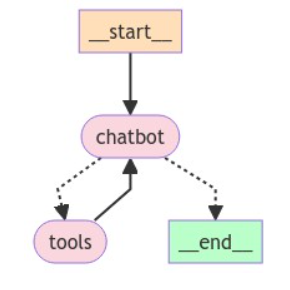

In [1]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
model = init_chat_model('gpt-4o')

In [6]:
client = MultiServerMCPClient(
    {
        "math": {
            "command": "python", 
            "args": ['/Users/mohamednajiaboo/Desktop/MCP_tutorials/lg_workflow/math-server.py'],
            'transport': 'stdio'
        },
        "weather":{
            'url': "http://localhost:8000/mcp/",
            "transport": "streamable_http"
        }
    }
)

In [7]:
tools = await client.get_tools()

In [12]:
tool_node = ToolNode(tools)

In [9]:
model_with_tools =  model.bind_tools(tools)

In [10]:
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [11]:
async def call_model(state: MessagesState):
    message = state["messages"]
    response = await model_with_tools.ainvoke(message)
    return {"messages": [response]}

In [16]:
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

In [17]:
builder.add_edge(START, 'call_model')
builder.add_conditional_edges(
    "call_model", 
    should_continue
)
builder.add_edge("tools", "call_model")

In [18]:
graph = builder.compile()

In [19]:
response1 = await graph.ainvoke(
    {
        "messages": [{"role": "user", "content": " What is (3+5) * 12?"}]
    }
)

In [20]:
response1

{'messages': [HumanMessage(content=' What is (3+5) * 12?', additional_kwargs={}, response_metadata={}, id='cfaf66cc-eaf7-41b3-b757-cd39a578e0b4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YtlumqsQt1tLnY3pd17edEvl', 'function': {'arguments': '{"a": 3, "b": 5}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_octS6coqa3DHBsUue6RZtXXq', 'function': {'arguments': '{"a": 8, "b": 12}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 97, 'total_tokens': 147, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C6Z7Kt0rsSNuvoSpxwKQuLVuoH4HK', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--31e9204e-4012-4892-87a8-2a3686545dc

In [21]:
response2 = await graph.ainvoke(
    {
        "messages": [{"role": "user", "content": " What is the weather in nyc?"}]
    }
)

In [22]:
response2

{'messages': [HumanMessage(content=' What is the weather in nyc?', additional_kwargs={}, response_metadata={}, id='75b25df3-2527-4874-b814-76638fb76c5b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cvt0aKLpxIukHcWtvV9IhYJk', 'function': {'arguments': '{"location":"nyc"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 94, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C6Z85jERlcCDldfocgVWttJcPkQo7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9b11e1f3-d811-44f2-a6d4-9f6dd1fa1a2f-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'nyc'}, 'id': 'call_cvt0aKLpxIukHcWtvV9IhYJk', '